A series of sanity checks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, random
from scipy.optimize import curve_fit

from local_utils import *

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'
aspect_ratio = 16./9

In [2]:
def calc_S(sigma):
    return np.sum(1./sigma**2)

def calc_Sx(x, sigma):
    return np.sum(x/sigma**2)

def calc_Sxx(x, sigma):
    return np.sum(x**2/sigma**2)

def calc_Sy(y, sigma):
    return np.sum(y/sigma**2)

def calc_Syy(y, sigma):
    return np.sum(y**2/sigma**2)

def calc_Sxy(x, y, sigma):
    return np.sum(x*y/sigma**2)

def calc_Delta(x, sigma):
    S = calc_S(sigma)
    Sxx = calc_Sxx(x, sigma)
    Sx = calc_Sx(x, sigma)
    
    return S*Sxx - Sx**2
    
def calc_cov(x, sigma):
    return -calc_Sx(x, sigma)/calc_Delta(x, sigma)

def calc_analytic_Delta(delta_x, sigma, N):  
    return delta_x**2/12/sigma**4*N**2*(N**2 - 1)

def calc_analytic_S(sigma, N):
    return N/sigma**2

def calc_analytic_Sx(delta_x, sigma, N):
    return 0.5*delta_x/sigma**2*(N - 1)*N

def calc_analytic_Sxx(delta_x, sigma, N):
    return delta_x**2/sigma**2*(N - 1)*N*(2*N - 1)/6

def calc_analytic_Delta(delta_x, sigma, N):
    return delta_x**2/sigma**4/12*N**2*(N**2 - 1)

def sigma_intercept(x, sigma):
    Sxx = calc_Sxx(x, sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(Sxx/Delta)

def sigma_slope(x, sigma):
    S = calc_S(sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(S/Delta)

def lin_fit(x, m, b):
    return m*x + b

def calc_slope(x, y, sigma):
    S = calc_S(sigma)
    Sx = calc_Sx(x, sigma)

    t = (x - Sx/S)/sigma
    Stt = calc_Sxx(t, np.ones_like(sigma))
        
    return np.sum(t*y/sigma)/Stt
    
def calc_intercept(x, y, sigma):
    slope = calc_slope(x, y, sigma)
    
    S = calc_S(sigma)
    Sx = calc_Sx(x, sigma)
    Sy = calc_Sy(y, sigma)
    
    return (Sy - Sx*slope)/S

def calc_analytic_intercept(delta_x, sigma, N, x, y):
    Sxx = calc_analytic_Sxx(delta_x, sigma, N)
    Sy = calc_Sy(y, sigma)
    Sx = calc_analytic_Sx(delta_x, sigma, N)
    Sxy = calc_Sxy(x, y, sigma)
    Delta = calc_analytic_Delta(delta_x, sigma, N)
   
    return (Sxx*Sy - Sx*Sxy)/Delta

def calc_analytic_slope(delta_x, sigma, N, x, y):
    S = calc_analytic_S(sigma, N)
    Sxy = calc_Sxy(x, y, sigma)
    Sx = calc_analytic_Sx(delta_x, sigma, N)
    Sy = calc_Sy(y, sigma)
    Delta = calc_analytic_Delta(delta_x, sigma, N)
    
    return (S*Sxy - Sx*Sy)/Delta

def calc_analytic_sigma_intercept(delta_x, sigma, N):
    return np.sqrt(2.*sigma**2*(2*N - 1)/N/(N + 1))

def calc_analytic_sigma_slope(delta_x, sigma, N):
    return np.sqrt(12*sigma**2/delta_x**2/N/(N**2 - 1))

In [3]:
# With sigma = 1, Sx/n should be the average value of x.
print(calc_S(sigma), calc_analytic_S(sigma[0], num_sensors))
print(calc_Sx(x, sigma), calc_analytic_Sx(delta_x, sigma[0], num_sensors))
# print(calc_Sy(y, sigma)/len(y), np.mean(y)) # There is no analytic Sy!
print(calc_Sxx(x, sigma), calc_analytic_Sxx(delta_x, sigma[0], num_sensors))
# print(calc_Syy(y, 1.)/len(y), np.mean(y**2))
# print(calc_Sxy(x, y, 1.)/len(x), np.mean(x*y))
print(calc_Delta(x, sigma), calc_analytic_Delta(delta_x, sigma[0], num_sensors))

NameError: name 'sigma' is not defined

In [5]:
# chisqg(ydata,ymod,sd=None)

z = np.array([1., 2., 4., 8.])
x = np.log(z/np.min(z))
delta_x = np.log(z[1]/z[0])
slope = 148.
intercept = 480.
y = slope*x + intercept
sigma = (np.max(y) - np.min(y))*2.

num_tries = 1

analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))    
analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))

for i in range(num_tries):
    noisy_y = (y + normal(scale=sigma, size=len(x)))
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma*np.ones_like(x), cov=True)
    unc = np.sqrt(np.diag(pcov))
    mod0 = np.polyval(popt, x)
    mod = np.polyval(popt + 0.5*unc, x)
    print(chisqg(noisy_y, mod, sd=sigma) - chisqg(noisy_y, mod0, sd=sigma))
    
    analytic_slope = calc_analytic_slope(delta_x, sigma, len(x), x, noisy_y)
    analytic_intercept = calc_analytic_intercept(delta_x, sigma, len(x), x, noisy_y)
    mod0 = np.polyval([analytic_slope, analytic_intercept], x)
    mod = np.polyval([analytic_slope + 0.5*analytic_sigma_slope, 
                      analytic_intercept + 0.5*analytic_sigma_intercept], 
                     x)
    print(chisqg(noisy_y, mod, sd=sigma) - chisqg(noisy_y, mod0, sd=sigma))
    
# #     popt, pcov = curve_fit(lin_fit, x, noisy_y)
#     slopes[i] = popt[0]
#     intercepts[i] = popt[1]
#     slopes_sigma[i] = np.sqrt(np.diag(pcov))[0]
#     intercepts_sigma[i] = np.sqrt(np.diag(pcov))[1]
    
# analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))    
# analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))

In [155]:
# chisqg(ydata,ymod,sd=None)

z = np.array([1., 2., 4., 8.])
x = np.log(z/np.min(z))
delta_x = np.log(z[1]/z[0])
slope = 148.
intercept = 480.
y = slope*x + intercept
sigma = (np.max(y) - np.min(y))*2.

num_tries = 1

analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))    
analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))

for i in range(num_tries):
    noisy_y = (y + normal(scale=sigma, size=len(x)))
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma*np.ones_like(x), cov=True)
    unc = np.sqrt(np.diag(pcov))
    mod0 = np.polyval(popt, x)
    mod = np.polyval(popt + 0.5*unc, x)
    print(chisqg(noisy_y, mod, sd=sigma) - chisqg(noisy_y, mod0, sd=sigma))
    
    analytic_slope = calc_analytic_slope(delta_x, sigma, len(x), x, noisy_y)
    analytic_intercept = calc_analytic_intercept(delta_x, sigma, len(x), x, noisy_y)
    mod0 = np.polyval([analytic_slope, analytic_intercept], x)
    mod = np.polyval([analytic_slope + 0.5*analytic_sigma_slope, 
                      analytic_intercept + 0.5*analytic_sigma_intercept], 
                     x)
    print(chisqg(noisy_y, mod, sd=sigma) - chisqg(noisy_y, mod0, sd=sigma))
    
# #     popt, pcov = curve_fit(lin_fit, x, noisy_y)
#     slopes[i] = popt[0]
#     intercepts[i] = popt[1]
#     slopes_sigma[i] = np.sqrt(np.diag(pcov))[0]
#     intercepts_sigma[i] = np.sqrt(np.diag(pcov))[1]
    
# analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))    
# analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))

2.191183140320397
1.843725393319379


18.911558478699124 25.691042765788183
18.049018828615832 23.405239052634293
19.856283640198132 25.748827108481073


<ErrorbarContainer object of 3 artists>

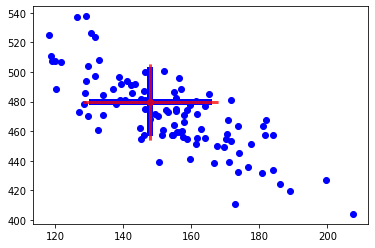

In [102]:
# Trying to figure out whether polyfit's uncertainties or NR's uncertainties are right
# z = np.array([ 150., 300., 600., 1200.])
z = np.array([1., 2., 4., 8.])
x = np.log(z/np.min(z))
slope = 148.
intercept = 480.
y = slope*x + intercept
sigma = (np.max(y) - np.min(y))/10

num_tries = 100

slopes = np.zeros(num_tries)
intercepts = np.zeros(num_tries)
slopes_sigma = np.zeros(num_tries)
intercepts_sigma = np.zeros(num_tries)

for i in range(num_tries):
    noisy_y = (y + normal(scale=sigma, size=len(x)))
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma*np.ones_like(x), cov=True)
#     popt, pcov = curve_fit(lin_fit, x, noisy_y)
    slopes[i] = popt[0]
    intercepts[i] = popt[1]
    slopes_sigma[i] = np.sqrt(np.diag(pcov))[0]
    intercepts_sigma[i] = np.sqrt(np.diag(pcov))[1]
    
analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))    
analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))
    
plt.scatter(slopes, intercepts, marker='o', color='blue')    
print(np.std(slopes), np.std(intercepts))
print(np.mean(slopes_sigma), np.mean(intercepts_sigma))
print(analytic_sigma_slope, analytic_sigma_intercept)
plt.errorbar([slope, slope], [intercept, intercept], xerr=[np.mean(slopes_sigma), np.mean(slopes_sigma)], 
             yerr=[np.mean(intercepts_sigma), np.mean(intercepts_sigma)], 
        marker='o', color='blue', lw=6)
plt.errorbar([slope, slope], [intercept, intercept], 
             xerr=[analytic_sigma_slope, analytic_sigma_slope], 
             yerr=[analytic_sigma_intercept, analytic_sigma_intercept], 
        marker='o', color='red', lw=3, alpha=0.5)

[107.37448828 507.98994603]
[34.72593907 45.031196  ]
2.0901615644827056
107.37448799095765 507.989946575
33.96871032275927 44.049252370071265


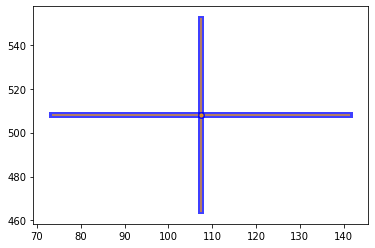

In [29]:
# Let's test these expressions
num_sensors = 4
base = 2.
delta_x = np.log(base)

# z = np.array([ 150., 300., 600., 1200.])
z = np.array([1., 2., 4., 8.])
x = np.log(z/np.min(z))

# slope = 114.26664167
# intercept = 522.18547383
slope = 148.
intercept = 480.
y = slope*x + intercept

sigma = np.mean([52.73472421, 42.93106227, 60.94672099, 53.98319914])
# sigma = 1.

num_tries = 1

analytic_sigma_slope = sigma_slope(x, sigma*np.ones_like(x))
analytic_sigma_intercept = sigma_intercept(x, sigma*np.ones_like(x))

for i in range(num_tries):
#     noisy_y = y + normal(scale=sigma, size=len(x))
    noisy_y = np.array([548.53654271, 521.12399152, 657.78736274, 751.06983102])
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma*np.ones_like(x), cov=True)
    unc = np.sqrt(np.diag(pcov))
#     print(popt)
#     print(unc)

    popt, pcov = curve_fit(lin_fit, x, noisy_y, sigma=sigma*np.ones_like(x), method='lm')
    unc = np.sqrt(np.diag(pcov))
    print(popt)
    print(unc)
    
    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
            marker='o', color='blue', alpha=0.5, lw=6)
       
    analytic_slope = calc_analytic_slope(delta_x, sigma, num_sensors, x, noisy_y)
    analytic_intercept = calc_analytic_intercept(delta_x, sigma, num_sensors, x, noisy_y)

    # Re-scale uncertainties
    mod = np.polyval([analytic_slope, analytic_intercept], x)
    redchisq = chisqg(noisy_y, mod, sd=sigma)
    inferred_sigma = sigma
    
#     if(redchisq > 1):
#         inferred_sigma = sigma*np.sqrt(redchisq)    
    
    analytic_sigma_slope = sigma_slope(x, inferred_sigma*np.ones_like(x))
    analytic_sigma_intercept = sigma_intercept(x, inferred_sigma*np.ones_like(x))

    print(redchisq)
    print(analytic_slope, analytic_intercept)
    print(analytic_sigma_slope, analytic_sigma_intercept)
    
    plt.errorbar([analytic_slope, analytic_slope], 
                 [analytic_intercept, analytic_intercept], 
                 xerr=[analytic_sigma_slope, analytic_sigma_slope], 
                 yerr=[analytic_sigma_intercept, analytic_sigma_intercept], 
            marker='.', color='orange', alpha=0.5)

#     plt.errorbar([analytic_slope, analytic_slope], 
#                  [analytic_intercept, analytic_intercept], 
#             marker='.', color='orange', alpha=0.5)

# analytic_slope = calc_analytic_slope(delta_x, sigma, num_sensors, x, noisy_y)
# analytic_slope_sigma = calc_analytic_sigma_slope(delta_x, sigma, num_sensors)
# analytic_intercept = calc_analytic_intercept(delta_x, sigma, num_sensors, x, noisy_y)
# analytic_intercept_sigma = calc_analytic_sigma_intercept(delta_x, sigma, num_sensors)

# Sxx = calc_analytic_Sxx(delta_x, sigma[0], num_sensors)
# Delta = calc_analytic_Delta(delta_x, sigma[0], num_sensors)

# plt.fill_between([analytic_slope - analytic_slope_sigma, analytic_slope + analytic_slope_sigma], 
#                  [analytic_intercept - analytic_intercept_sigma, analytic_intercept - analytic_intercept_sigma],
#                  [analytic_intercept + analytic_intercept_sigma, analytic_intercept + analytic_intercept_sigma],
#                 alpha=0.5)

# numerical_slope = calc_slope(x, noisy_y, sigma)
# numerical_slope_sigma = sigma_slope(x, sigma)
# numerical_intercept = calc_intercept(x, noisy_y, sigma)
# numerical_intercept_sigma = sigma_intercept(x, sigma)

# plt.fill_between([numerical_slope - numerical_slope_sigma, numerical_slope + numerical_slope_sigma], 
#                  [numerical_intercept - numerical_intercept_sigma, numerical_intercept - numerical_intercept_sigma],
#                  [numerical_intercept + numerical_intercept_sigma, numerical_intercept + numerical_intercept_sigma],
#                 alpha=0.5)

$$
m = \frac{u_\star}{\kappa}\\
b = -\frac{u_\star}{\kappa} \ln \left( \frac{z_0}{z_\star} \right) = -m \ln \left( \frac{z_0}{z_\star} \right)
$$

$$
\sigma_{z_\star} = z_\star \frac{b}{m} \sqrt{ \left( \frac{\sigma_m}{m} \right)^2 + \left( \frac{\sigma_m}{b} \right)^2 - 2\left( \frac{\sigma_{bm}}{bm} \right) }
$$

[59.33410023  5.87216811]
40.51705465955948


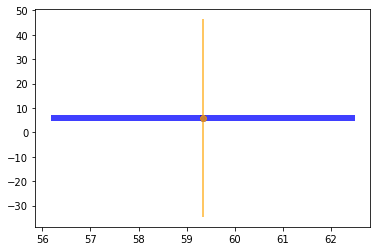

In [31]:
# Let's test these expressions
num_sensors = 4
base = 2.
delta_x = np.log(base)

# sigma = 0.1*np.ones(num_sensors)
# slope = 10.
# intercept = 1.
# kappa = 0.4
# z = base**(np.linspace(0, num_sensors - 1, num_sensors))

# ustar = kappa*slope
# zstar = np.min(z)*np.exp(-intercept/slope)

z = np.array([ 150., 300., 600., 1200.])
x = np.log(z/np.min(z))

# sigma = np.mean([34.08092668, 43.10055741, 38.10124155, 39.29545398])
sigma = 15.

num_tries = 1

for i in range(num_tries):
#     noisy_y = y + normal(scale=sigma[0], size=num_sensors)
    noisy_y = np.array([485.87922694, 582.45590446, 672.72655129, 798.51621406])
    
    popt, pcov = curve_fit(calc_wind_profile, z, noisy_y, sigma=sigma*np.ones(num_sensors), p0=[50., 2.])
    unc = np.sqrt(np.diag(pcov))
    print(popt)

    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
                marker='o', color='blue', alpha=0.5, lw=6)
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma*np.ones(num_sensors), cov=True)
    sigma_bm = pcov[1,0]
    unc = np.sqrt(np.diag(pcov))

    unc = [calc_analytic_sigma_slope(delta_x, sigma, num_sensors), 
           calc_analytic_sigma_intercept(delta_x, sigma, num_sensors)]
    sigma_bm = calc_cov(x, sigma)

    numerical_ustar = calc_ustar(*popt, np.min(z))
    numerical_sigma_ustar = calc_sigma_ustar(*popt, np.min(z), *unc, sigma_bm)
    numerical_zstar = calc_zstar(*popt, np.min(z))
    numerical_sigma_zstar = calc_sigma_zstar(*popt, np.min(z), *unc, sigma_bm)
    print(numerical_sigma_zstar)
    
    plt.errorbar([numerical_ustar, numerical_ustar], 
                 [numerical_zstar, numerical_zstar], 
                 xerr=[numerical_sigma_ustar, numerical_sigma_ustar], 
                 yerr=[numerical_sigma_zstar, numerical_sigma_zstar], 
            marker='o', color='orange', alpha=0.5)


In [30]:
# But if I use polyfit's uncertainties, I recover ustar/zstar uncertainties that are consistent with curve_fit's.

# Let's test these expressions
num_sensors = 5
base = 2.
delta_x = np.log(base)
sigma = 50.
slope = 100.
intercept = 500.
kappa = 0.4

z = base**(np.linspace(0, num_sensors - 1, num_sensors))
x = np.log(z/np.min(z))
y = np.polyval([slope, intercept], x)

ustar = kappa*slope
zstar = np.min(z)*np.exp(-intercept/slope)

print(ustar, zstar)
print()

num_tries = 10

for i in range(num_tries):
    noisy_y = y + normal(scale=sigma, size=num_sensors)
    
    popt, pcov = curve_fit(calc_wind_profile, z, noisy_y, sigma=sigma, p0=[ustar, zstar])
    unc = np.sqrt(np.diag(pcov))
    print(unc)

    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
                marker='o', color='blue', alpha=0.5, lw=6)
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
    sigma_bm = pcov[1,0]
    unc = np.sqrt(np.diag(pcov))

    numerical_ustar = calc_ustar(*popt, np.min(z))
    numerical_zstar = calc_zstar(*popt, np.min(z))

    numerical_sigma_ustar = calc_sigma_ustar(delta_x, sigma[0], num_sensors, 
                                             numerical_ustar, numerical_zstar, np.min(z))
    numerical_sigma_zstar = calc_sigma_zstar(delta_x, sigma[0], num_sensors, 
                                             numerical_ustar, numerical_zstar, np.min(z))
    print(numerical_sigma_ustar, numerical_sigma_zstar)
    
    plt.errorbar([numerical_ustar, numerical_ustar], 
                 [numerical_zstar, numerical_zstar], 
                 xerr=[numerical_sigma_ustar, numerical_sigma_ustar], 
                 yerr=[numerical_sigma_zstar, numerical_sigma_zstar], 
            marker='o', color='orange', alpha=0.5)


40.0 0.006737946999085467



NameError: name 'calc_wind_profile' is not defined